# AMG+ for 1D Helmholtz: The Repetitive Case
* Constant $k$.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.

In [12]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [60]:
# Fixed seed for reproducible results.
np.random.seed(1)

# Domain size.
n = 96
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "3-point"
kh = 0
#kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]

repetitive = True

# Test vectors.
ideal_tv = True #. False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 2
# Set # sweeps manually here.
num_sweeps_on_vectors = 1000 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "weighted_ls" #"ls"
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0


## Level 0->1 Coarsening

In [61]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# TV and TV residual history.
x_log = []
r_log = []

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.104e+00                    4.468e-01    2.467
INFO     1     4.083e-01 (0.370) [0.370]    2.507e-01    1.629 (0.660)
INFO     2     1.612e-01 (0.395) [0.383]    1.778e-01    0.907 (0.558)
INFO     3     7.145e-02 (0.444) [0.402]    1.470e-01    0.486 (0.537)
INFO     4     3.681e-02 (0.515) [0.428]    1.306e-01    0.283 (0.581)
INFO     5     2.197e-02 (0.596) [0.458]    1.204e-01    0.184 (0.648)
INFO     6     1.484e-02 (0.675) [0.488]    1.133e-01    0.132 (0.718)
INFO     7     1.091e-02 (0.735) [0.518]    1.081e-01    0.102 (0.772)
INFO     8     8.450e-03 (0.776) [0.545]    1.040e-01    0.083 (0.807)
INFO     9     6.803e-03 (0.806) [0.569]    1.007e-01    0.069 (0.833)
INFO     10    5.637e-03 (0.829) [0.591]    9.786e-02    0.059 (0.853)
INFO     11    4.777e-03 (0.847) [0.610]    9.547e-02    0.051 (0.869)
INFO     12    4.123e-03 (0.862) [0.628]    9.340e-02    0.046 (0.883)
INFO 

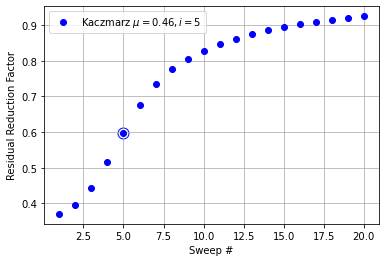

In [62]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95)
num_sweeps = method_info["Kaczmarz"][1]

In [63]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 2 ideal TVs


### Coarsening: Fixed (4/2)

In [64]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 2 #4
num_components = 1 #2

# Optimize aggregate_size, num_components using mock cycle rates.
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

,0,1,2,3,4,5,6,7,8,9
0,0.50,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.50,0.50,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.50,0.50,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.50,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.50


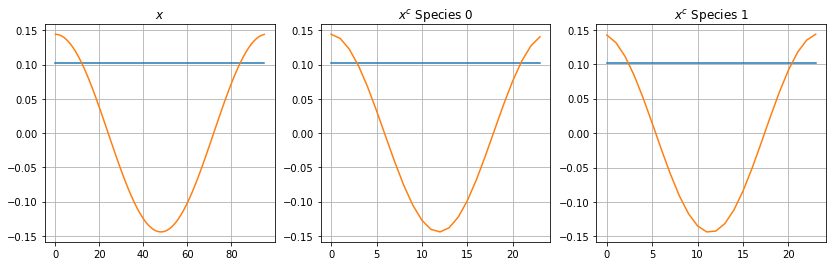

In [65]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=True)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
The mock cycle rate is calculated on a domain of size $4 a$, $a$ = aggregate size.

In [66]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=8 [0.248 0.104 0.045 0.03  0.016]


### Interpolation $P = R^T$

In [67]:
# Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()
print(p.todense())

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy(
            kh, discretization, m * aggregate_size, r.asarray(), p, aggregate_size), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "Two-level")).transpose()
display(conv)

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

[[0.501]
 [0.499]]


,1,2,3,4,5
Mock,0.25,0.10,0.05,0.03,0.02
Two-level,0.51,0.41,0.43,0.34,0.36


INFO     L2 projection norm 0.71 A*A' projection norm 1.41


This intepolation is good up to $\nu = 2$, conv $\approx 0.5$.

### Interpolation by LS Fitting

In [68]:
calibers = (2,) #(2, 3, 4)
for use_r_as_restriction in (False, ): #(False, True):
    print("R*A*P" if use_r_as_restriction else "P^T*A*P")
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, interpolation_method, aggregate_size=aggregate_size, nc=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber)
        print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))

        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, 
                    use_r_as_restriction=use_r_as_restriction), 
                nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append(two_level_conv)
        p_caliber.append(p)

    conv = pd.DataFrame(np.array([mock_conv] + l2c).transpose(), 
                        index=nu_values, columns=("Mock",) + tuple("Caliber {}".format(caliber)
                                                                  for caliber in calibers)).transpose()
    display(conv)

P^T*A*P
INFO     caliber 2 error l2 [0.00] a [7.40e-01]
p row sums [1. 1. 1. 1. 1.]


,1,2,3,4,5
Mock,0.25,0.10,0.05,0.03,0.02
Caliber 2,0.48,0.21,0.14,0.14,0.10


In [69]:
for caliber, p in zip(calibers, p_caliber):
#    styler = pd.DataFrame(p[:8, :8].todense()).style.set_table_attributes("style='display:inline'").set_caption("Caliber {}".format(caliber)).format(precision=2)   
#    display_html(styler._repr_html_(), raw=True)
    ml = hm.repetitive.locality.create_two_level_hierarchy(kh, discretization, n, R, p, None, use_r_as_restriction=use_r_as_restriction)
    ac = ml[1].a
    print("caliber {} nnz(P) {} fill-in {:.2f}".format(caliber, p.nnz, (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])))
    print("Max abs |Ac - Ac^T| {:.3e}".format(np.max(np.abs(ac - ac.transpose()))))
    display_df_side_by_side(pd.DataFrame(p[:6, :6].todense()),
                            pd.DataFrame(ac.todense()[:10,:10]), 
                        captions=("P", "A^1"))

caliber 2 nnz(P) 192 fill-in 1.67
Max abs |Ac - Ac^T| 5.551e-17


P 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 0 
 0.76 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.75 
 0.25 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.24 
 0.76 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.75 
 0.25 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.24 
 0.76 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.75 
 0.25 
 0.00 
 0.00 
 
 
 

 
 A^1 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 0 
 -0.64 
 0.26 
 0.06 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 0.26 
 -0.64 
 0.26 
 0.06 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.06 
 0.26 
 -0.64 
 0.26 
 0.06 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.00 
 0.06 
 0.26 
 -0.64 
 0.26 
 0.06 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.06 
 0.26 
 -0.64 
 0.26 
 0.06 
 0.00 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.00 
 0.06 
 0.26 
 -0.64 
 0.26 
 0.06 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.06 
 0.26 
 -0.64 
 0.26 
 0.06 
 0.00 
 
 
 7 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.06 
 0.26 
 -0.64 
 0.26 
 0.06 
 
 
 8 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.06 
 0.26 
 -0.64 
 0.26 
 
 
 9 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.06 
 0.26 
 -0.64

$R A P$ is nearly symmetric, and is sparser than $P^T A P$, while giving almost the same 2-level convergence factors for $\nu \geq 2$.

### Solving $Ax = b$ - Convergence History

#### $P^T A P$

INFO         0 |r| 1.614e+01 RER 2.75206
INFO         1 |r| 1.129e+00 (0.06994) RER 0.12407 (0.04508) 9.101
INFO         2 |r| 1.349e-01 (0.11950) RER 0.01099 (0.08861) 12.275
INFO         3 |r| 1.831e-02 (0.13570) RER 0.00088 (0.07991) 20.844
INFO         4 |r| 2.525e-03 (0.13791) RER 0.00010 (0.11152) 25.777
INFO         5 |r| 3.535e-04 (0.14000) RER 0.00001 (0.11081) 32.565
INFO         6 |r| 4.957e-05 (0.14021) RER 0.00000 (0.11628) 39.267
INFO         7 |r| 6.975e-06 (0.14073) RER 0.00000 (0.11093) 49.816
INFO         8 |r| 9.253e-07 (0.13266) RER 0.00000 (0.09219) 71.683
INFO         9 |r| 1.161e-07 (0.12550) RER 0.00000 (0.08289) 108.531
INFO        10 |r| 1.450e-08 (0.12488) RER 0.00000 (0.09463) 143.228
INFO        11 |r| 2.078e-09 (0.14332) RER 0.00000 (0.12531) 163.818
INFO        12 |r| 2.926e-10 (0.14076) RER 0.00000 (0.11076) 208.195
INFO        13 |r| 4.217e-11 (0.14414) RER 0.00000 (0.11826) 253.761


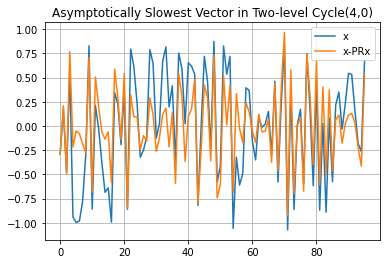

In [71]:
nu = 4
p = p_caliber[0]
multilevel = hm.repetitive.locality.create_two_level_hierarchy(
    kh, discretization, n, R, p, aggregate_size, use_r_as_restriction=False)
y, _ = hm.repetitive.locality.two_level_conv_factor(multilevel, nu, print_frequency=1,
                                                   debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
y -= y.mean() # Remove zero component.
e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [73]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:12])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel[k].p.dot(v)
    vl_finest.append(v)

0 lam [ 0.    -0.004 -0.004 -0.017 -0.017 -0.038 -0.038 -0.068 -0.068 -0.106 -0.106 -0.152]
1 lam [-0.    -0.009 -0.009 -0.034 -0.034 -0.075 -0.075 -0.13  -0.13  -0.196 -0.196 -0.272]


<!-- #### $P^T A Q$ -->

In [74]:
# nu = 4
# p = p_caliber[-1]
# multilevel = hm.repetitive.locality.create_two_level_hierarchy(
#     kh, discretization, n, R, p, aggregate_size, use_r_as_restriction=True)
# y, _ = hm.repetitive.locality.two_level_conv_factor(multilevel, nu, print_frequency=1,
#                                                    debug=False)

# # Asymptotic vector.
# plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
# plt.plot(y, label="x");
# plt.plot(e, label="x-PRx");
# plt.grid(True);
# plt.legend();

In [75]:
# y.T.dot(multilevel[0].a.dot(y)) / (y.T.dot(y))

In [76]:
# # Calculate eigenpairs at all levels.
# vl = []
# laml = []
# for l, level in enumerate(multilevel):
#     a = level.a
#     lam, v = eig(a.todense())
#     lam = np.real(lam)
#     ind = np.argsort(np.abs(lam))
#     lam = lam[ind]
#     v = v[:, ind]
#     vl.append(v)
#     laml.append(lam)
#     print(l, "lam", lam[:12])
    
# # Interpolate eigenvectors at all levels to the finest level.
# num_levels = len(multilevel)
# vl_finest = []
# for l in range(num_levels):
#     v = vl[l]
#     for k in range(l, 0, -1):
#         v = multilevel[k].p.dot(v)
#     vl_finest.append(v)